In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc as pm
import arviz as az
from scipy.stats import mode
from sklearn.preprocessing import MinMaxScaler

from get_model_training_data_05 import get_features_and_data

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

# warnings.filterwarnings("ignore")
# os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def precision_and_recall(df, true_col="release", pred_col="release_pred"):
    true_positives = len(df[(df[true_col] == 1) & (df[pred_col] == 1)])
    false_positives = len(df[(df[true_col] != 1) & (df[pred_col] == 1)])
    false_negatives = len(df[(df[true_col] == 1) & (df[pred_col] != 1)])

    return (np.round(true_positives / (true_positives + false_positives), 3),
            np.round(true_positives / (true_positives + false_negatives), 3))

## Load Training and Testing Data

In [4]:
(df, train_df, test_df, feature_names, next_two_weeks) = get_features_and_data()

/Users/diane/Library/CloudStorage/Dropbox/troon_release_prediction/get_model_training_data_05.py:83: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["release_preorder"] = df["release_preorder"].fillna(False)


training examples = 700, testing examples = 83


/Users/diane/Library/CloudStorage/Dropbox/troon_release_prediction/get_model_training_data_05.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["previous_release_preorder"] = df["release_preorder"].shift().fillna(False).astype(int)


In [5]:
feature_names = ["days_since_previous_release",
                 # "release_prob",
                 "days_until_next_holiday",
                 # "WD_Thursday",
                 # "WD_Wednesday",
                 # "previous_release_preorder",
                 "WD_Tuesday",
                 "WD_Saturday",
                 "WD_Monday",
                 "previous_release",
                 "WD_Sunday"]

In [6]:
train_df["release"].value_counts()

release
0    584
1    116
Name: count, dtype: Int64

In [7]:
train_df = pandas.concat(
    [train_df[train_df["release"] == 0].sample(n=int(len(train_df[train_df["release"] == 0]) // 2), random_state=1024),
     train_df[train_df["release"] == 1]], ignore_index=True).sort_values(by=["index"])

In [8]:
n = int(len(df[(df["release"] == 0) & (df["year"] < 2024)]) // 3)

df = pandas.concat(
    [df[(df["release"] == 0) & (df["year"] < 2024)].sample(n=n, random_state=1024),
     df[(df["release"] == 0) & (df["year"] == 2024)],
     df[df["release"] == 1]], ignore_index=True).sort_values(by=["index"])

In [9]:
train_df.groupby(["year", "release"]).size().reset_index().pivot(index="year", columns="release", values=0)

release,0,1
year,,
2023,159,58
2024,133,58


In [10]:
df.groupby(["year", "release"]).size().reset_index().pivot(index="year", columns="release", values=0)

release,0,1
year,,
2023,102.0,58.0
2024,302.0,64.0
2025,NaN,10.0


In [11]:
scale_features = ["days_since_previous_release", "days_until_next_holiday"]

In [12]:
scaler = MinMaxScaler().fit(train_df[scale_features])
train_df[scale_features] = scaler.transform(train_df[scale_features])
test_df[scale_features] = scaler.transform(test_df[scale_features])

In [13]:
scaler = MinMaxScaler().fit(df[scale_features])
df[scale_features] = scaler.transform(df[scale_features])
next_two_weeks[scale_features] = scaler.transform(next_two_weeks[scale_features])

## Model-Building and Evaluation

In [14]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", train_df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    # linear model
    release_prob = pm.math.invlogit(beta0 + pm.math.dot(weights, features))
    release = pm.Bernoulli(
        "release",
        p=release_prob,
        observed=train_df["release"].values,
        shape=features.shape[1],
    )

/Users/diane/miniconda3/lib/python3.12/site-packages/pymc/data.py:272: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [15]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [16]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,2.06,0.56,1.03,3.10,0.01,0.01,3110.77,2988.47,1.0
days_until_next_holiday,0.39,0.46,-0.50,1.23,0.01,0.01,4292.84,2918.89,1.0
WD_Tuesday,-0.94,0.32,-1.54,-0.34,0.00,0.00,4625.07,3194.29,1.0
WD_Saturday,-1.35,0.43,-2.13,-0.52,0.01,0.00,4671.16,3014.04,1.0
WD_Monday,-1.56,0.38,-2.24,-0.83,0.01,0.00,4850.21,3257.87,1.0
WD_Sunday,-2.33,0.48,-3.32,-1.50,0.01,0.00,5327.00,3320.96,1.0
previous_release,-2.38,0.60,-3.54,-1.35,0.01,0.01,4617.04,2736.51,1.0


In [17]:
az.summary(idata, round_to=2, var_names=["beta0"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.79,0.27,-1.29,-0.3,0.01,0.0,2521.23,2845.32,1.0


### Out-of-Sample Evaluation

In [18]:
with model:
    pm.set_data({"features" : test_df[feature_names].T})
    pred_test = pm.sample_posterior_predictive(idata, predictions=True, var_names=["release"])

Sampling: [release]


Output()

In [19]:
test_df["release_pred"] = [mode(p)[0] for p in pred_test["predictions"]["release"].stack(all_draws=["chain", "draw"]).values]

In [20]:
test_df["release_pred"].value_counts()

release_pred
0    77
1     6
Name: count, dtype: int64

In [21]:
test_df["release"].value_counts()

release
0    67
1    16
Name: count, dtype: Int64

In [22]:
precision_and_recall(test_df)

(np.float64(0.667), np.float64(0.25))

In [23]:
test_df["release_pred_prob"] = np.mean(pred_test["predictions"]["release"].stack(all_draws=["chain", "draw"]).values, axis=1)

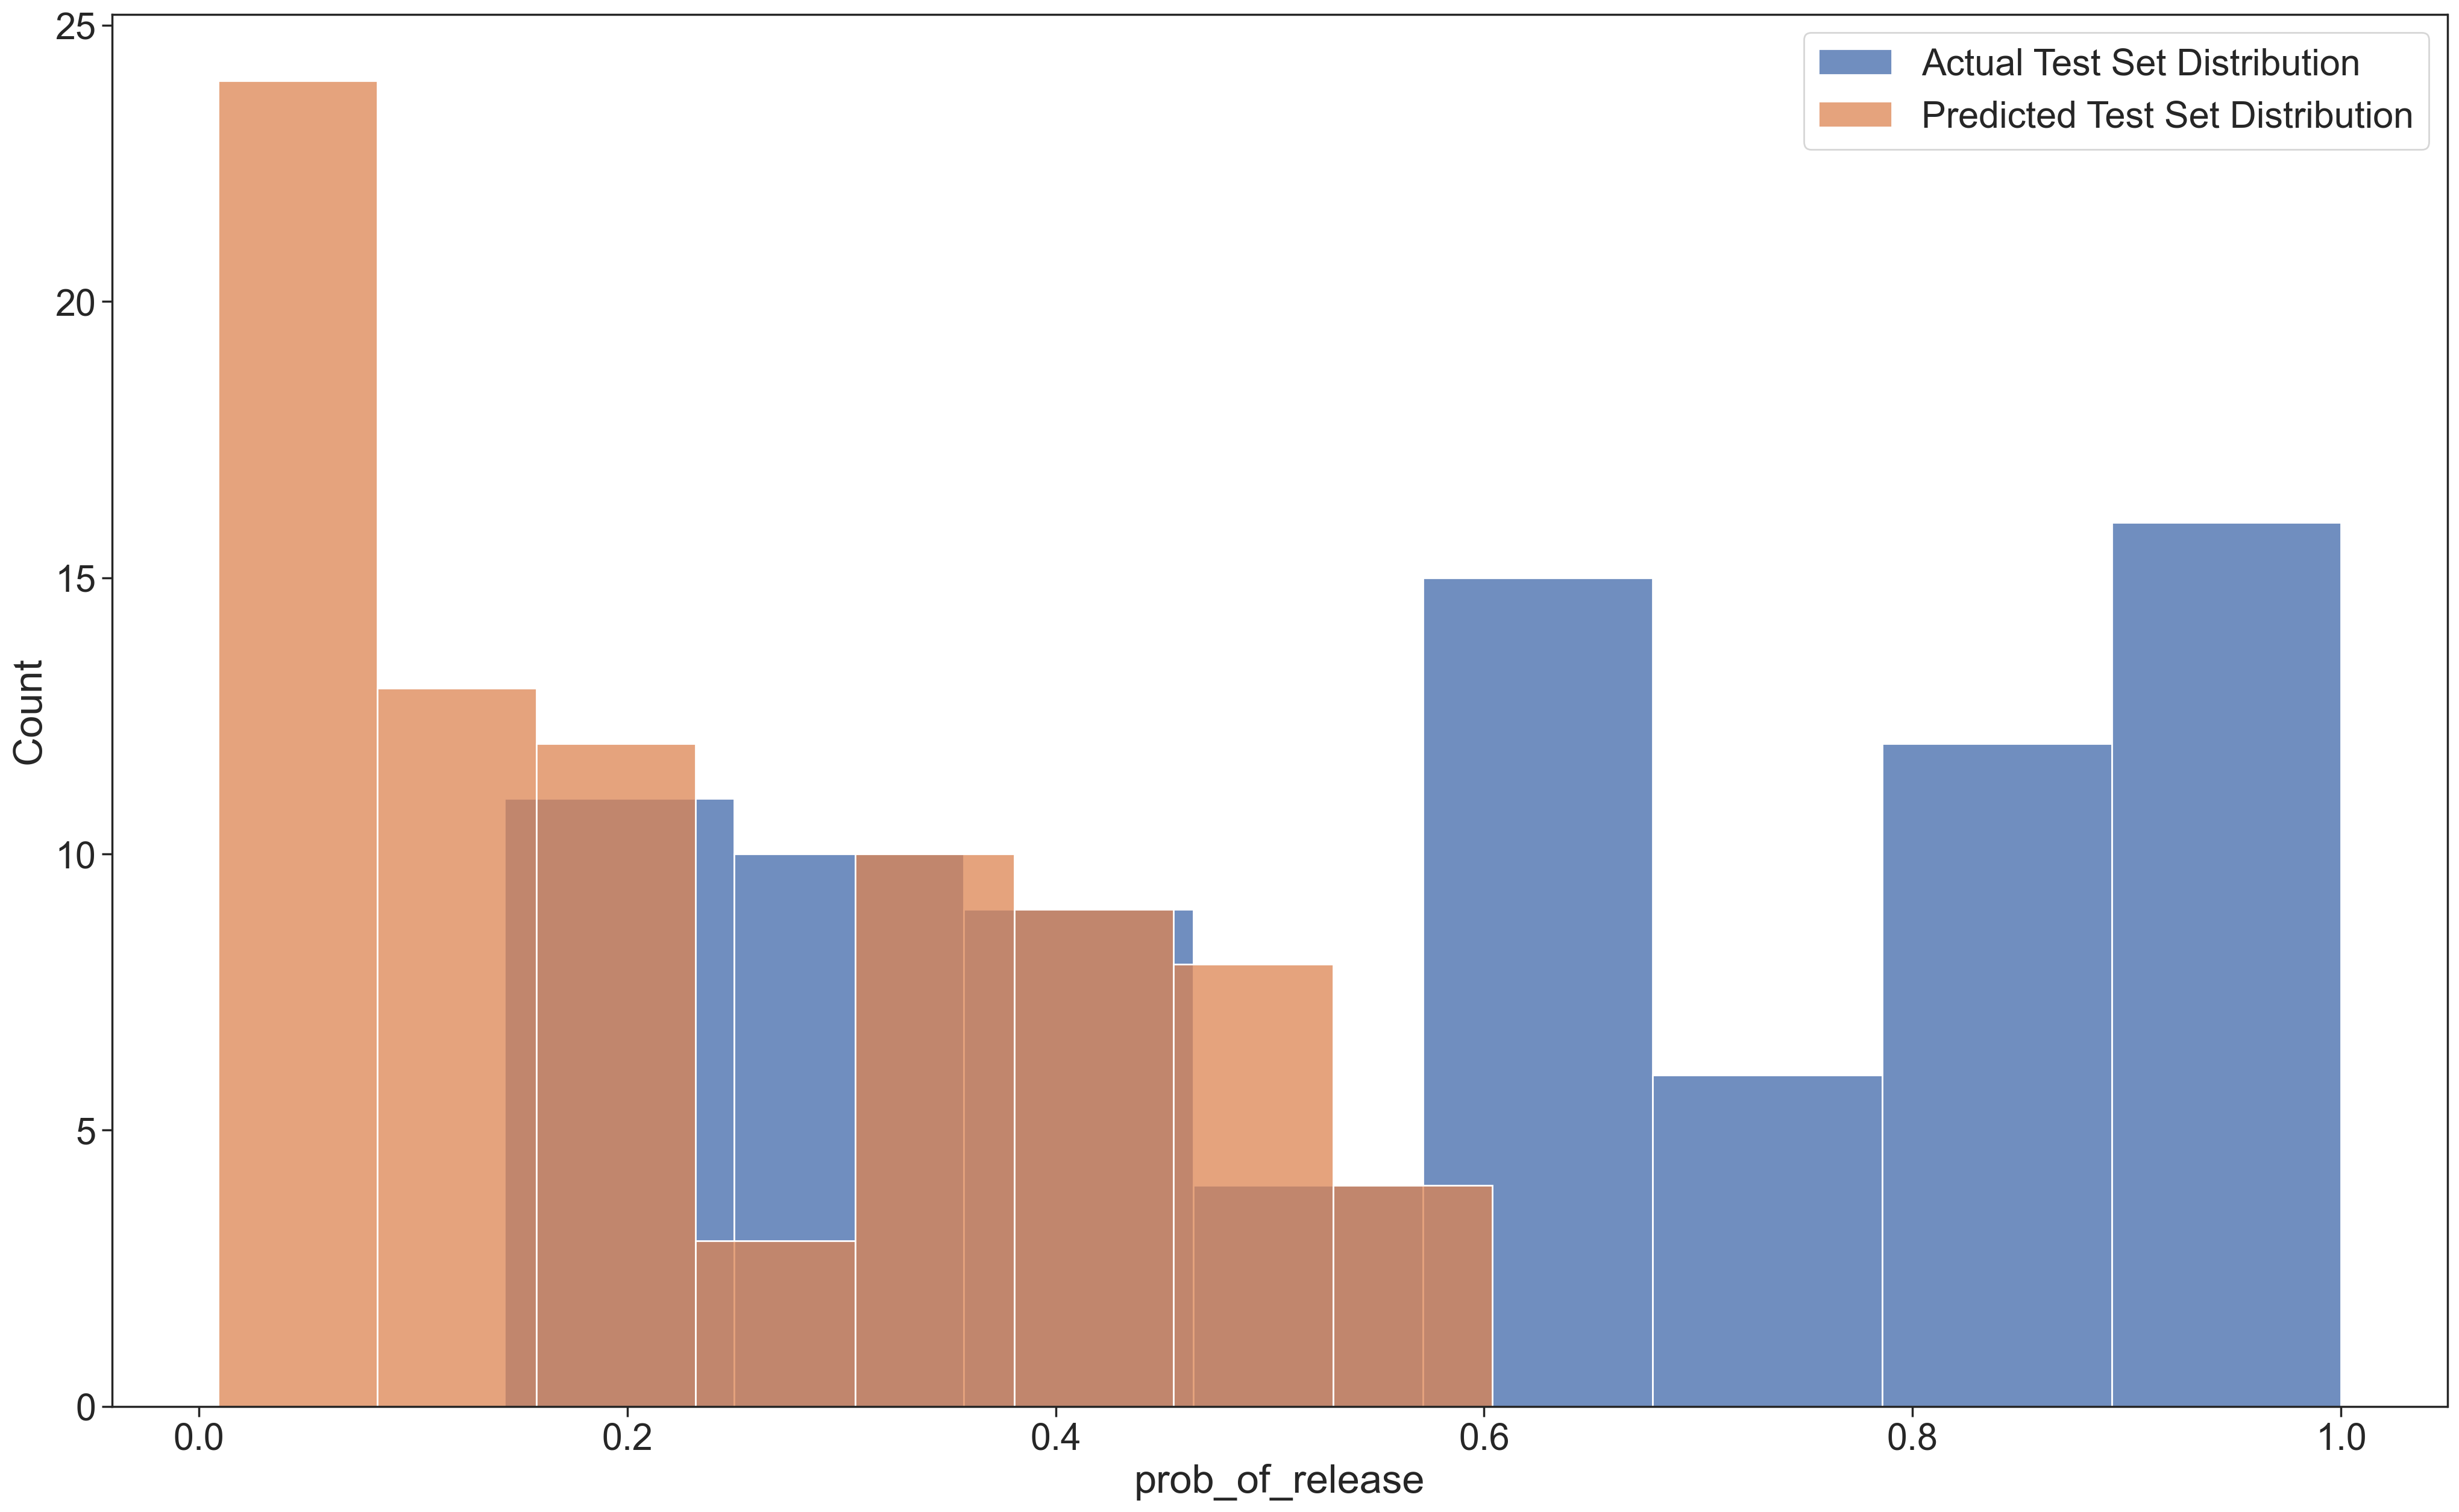

In [24]:
ax = sns.histplot(x=test_df["prob_of_release"], alpha=0.8, label="Actual Test Set Distribution")
sns.histplot(x=test_df["release_pred_prob"], ax=ax, label="Predicted Test Set Distribution")
ax.legend()
plt.show()

## Predictions for the Next Two Weeks

In [25]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    # linear model
    release_prob = pm.math.invlogit(beta0 + pm.math.dot(weights, features))
    release = pm.Bernoulli(
        "release",
        p=release_prob,
        observed=df["release"].values,
        shape=features.shape[1],
    )

/Users/diane/miniconda3/lib/python3.12/site-packages/pymc/data.py:272: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [26]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [27]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,2.71,0.53,1.70,3.68,0.01,0.01,3390.18,3092.22,1.0
days_until_next_holiday,0.10,0.43,-0.73,0.85,0.01,0.01,4846.76,3213.98,1.0
WD_Tuesday,-0.67,0.29,-1.20,-0.14,0.00,0.00,4881.02,3443.56,1.0
WD_Saturday,-1.40,0.42,-2.20,-0.66,0.01,0.00,5389.12,3132.38,1.0
WD_Monday,-1.77,0.39,-2.52,-1.09,0.01,0.00,5035.92,3039.85,1.0
WD_Sunday,-2.22,0.44,-3.03,-1.40,0.01,0.00,4566.85,2758.89,1.0
previous_release,-2.28,0.59,-3.40,-1.21,0.01,0.01,5103.48,2914.65,1.0


In [28]:
az.summary(idata, round_to=2, var_names=["beta0"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-1.1,0.25,-1.58,-0.64,0.01,0.0,2386.78,2634.51,1.0


In [29]:
with model:
    pm.set_data({"features" : next_two_weeks[feature_names].T})
    pred_next = pm.sample_posterior_predictive(idata, predictions=True, var_names=["release"])

Sampling: [release]


Output()

In [30]:
next_two_weeks["release_pred"] = [mode(p)[0] for p in pred_next["predictions"]["release"].stack(all_draws=["chain", "draw"]).values]

In [31]:
next_two_weeks["release_pred_prob"] = np.mean(pred_next["predictions"]["release"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [32]:
next_two_weeks[["index", "release_pred", "release_pred_prob"]].round(4)

,index,release_pred,release_pred_prob
0,2025-02-28,1,0.5455
1,2025-03-01,0,0.2742
2,2025-03-02,0,0.1768
3,2025-03-03,0,0.2745
4,2025-03-04,1,0.5850
5,2025-03-05,1,0.7692
6,2025-03-06,1,0.7847
7,2025-03-07,1,0.8330
8,2025-03-08,1,0.5985
9,2025-03-09,0,0.4598


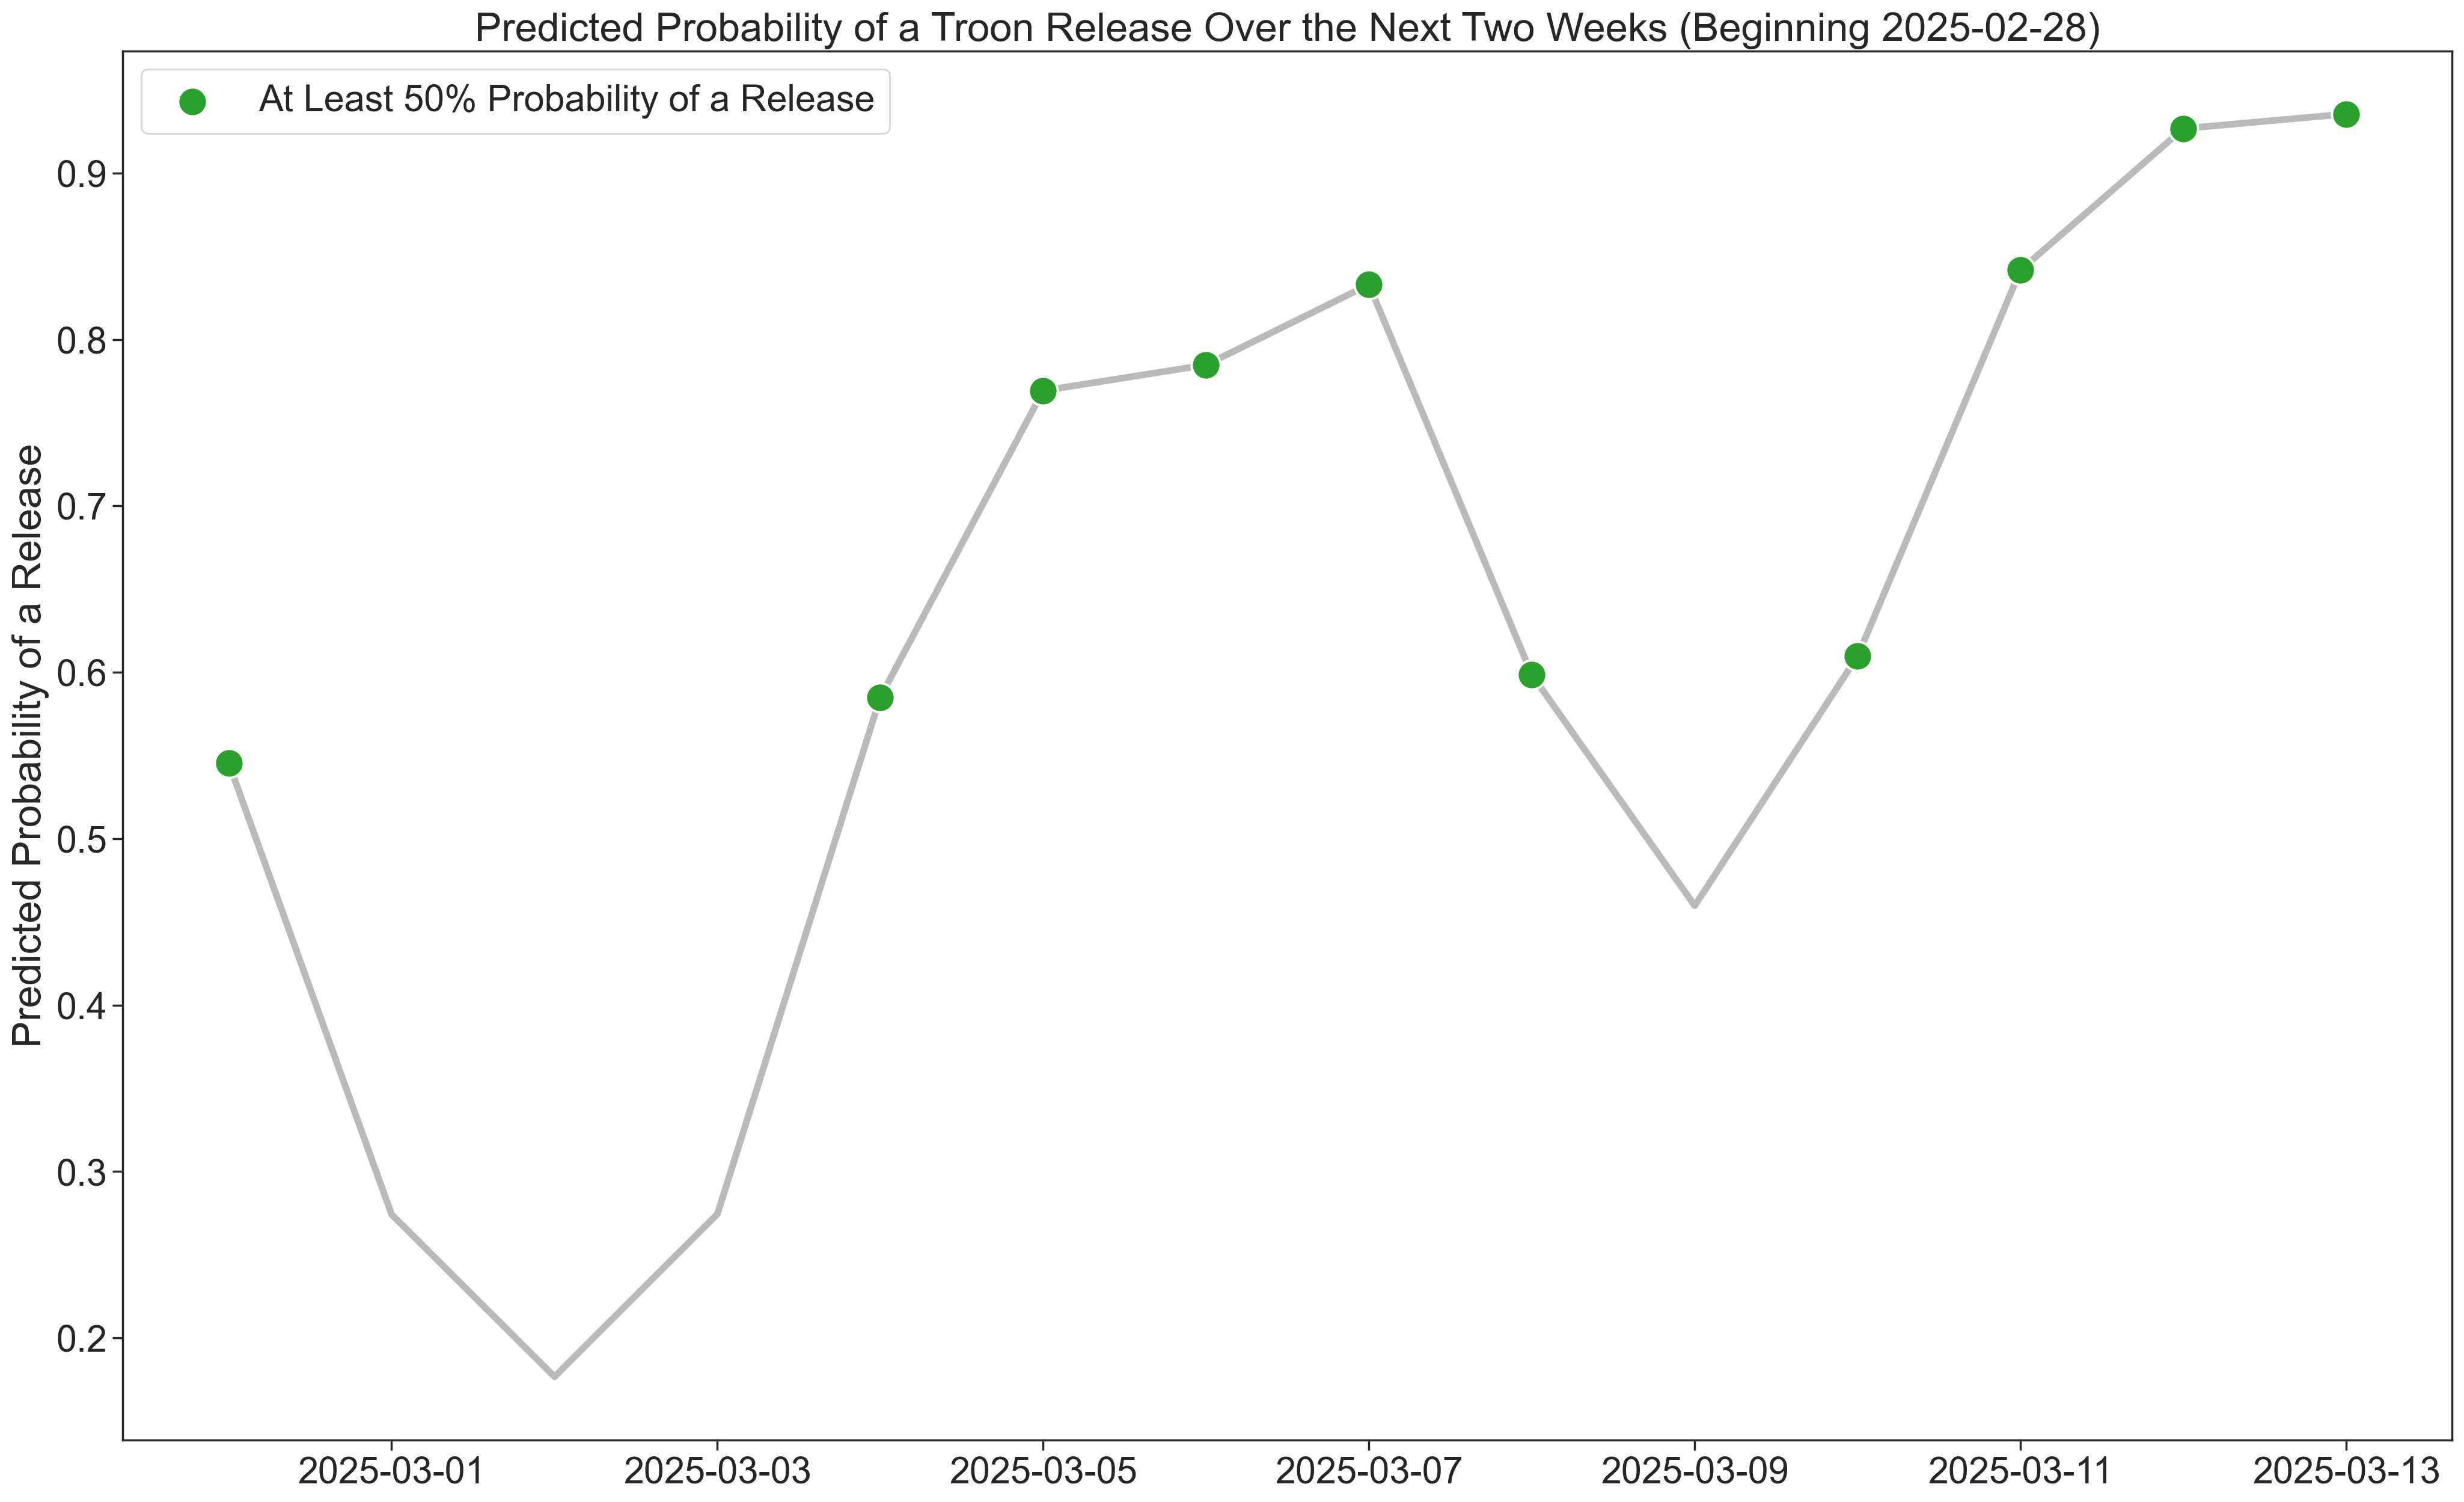

In [33]:
ax = sns.lineplot(data=next_two_weeks, x="index", y="release_pred_prob", linewidth=4, color="darkgrey", alpha=0.8)
sns.scatterplot(data=next_two_weeks[next_two_weeks["release_pred"] == 1], x="index", y="release_pred_prob", s=300,
                color="tab:green", label="At Least 50% Probability of a Release", ax=ax, zorder=2)
ax.set_xlabel(None)
ax.set_ylabel("Predicted Probability of a Release")
ax.set_title("Predicted Probability of a Troon Release Over the Next Two Weeks (Beginning {})".format(
    next_two_weeks["index"].iloc[0].date()))
ax.legend()
plt.show()